In [4]:
import numpy as np
import scipy.stats as s
import empiricaldist as ed
import matplotlib.pyplot as plt
from collections import Counter
from utils import decorate

In [5]:
actual_probs = [0.10, 0.20, 0.30, 0.40]

xs = np.linspace(0, 1, 101)
prior = ed.Pmf(1, xs)
prior.normalize()

beliefs = [prior.copy() for i in range(4)]

In [6]:
options = dict(xticklabels='invisible', yticklabels='invisible')

def plot(beliefs, **options):
    for i, pmf in enumerate(beliefs):
        plt.subplot(2, 2, i+1)
        pmf.plot(label='Machine %s' % i)
        decorate(yticklabels=[])
        
        if i in [0, 2]:
            decorate(ylabel='PDF')
        
        if i in [2, 3]:
            decorate(xlabel='Probability of winning')
        
    plt.tight_layout()

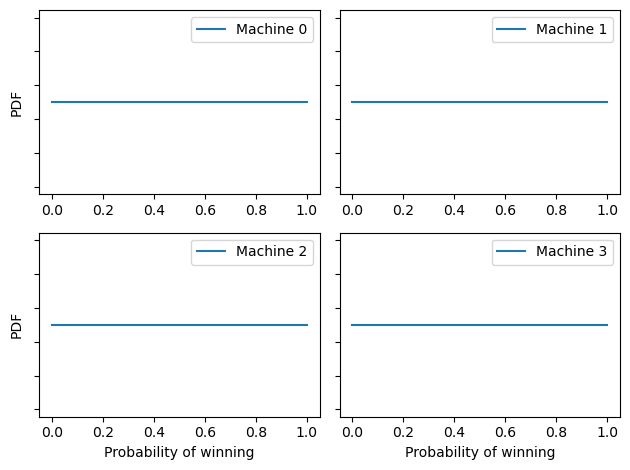

In [7]:
plot(beliefs)

In [8]:
likelihood = {
    'W': xs,
    'L': 1 - xs
}

def update(pmf, data):
    """Update the probability of winning."""
    pmf *= likelihood[data]
    pmf.normalize()

In [9]:
# count how many times we've played each machine
counter = Counter()

def play(i):
    """Play machine i.
    
    i: index of the machine to play
    
    returns: string 'W' or 'L'
    """
    counter[i] += 1
    p = actual_probs[i]
    if np.random.random() < p:
        return 'W'
    else:
        return 'L'

In [11]:
for i in range(len(beliefs)):
    for _ in range(10):
        outcome = play(i)
        update(beliefs[i], outcome)

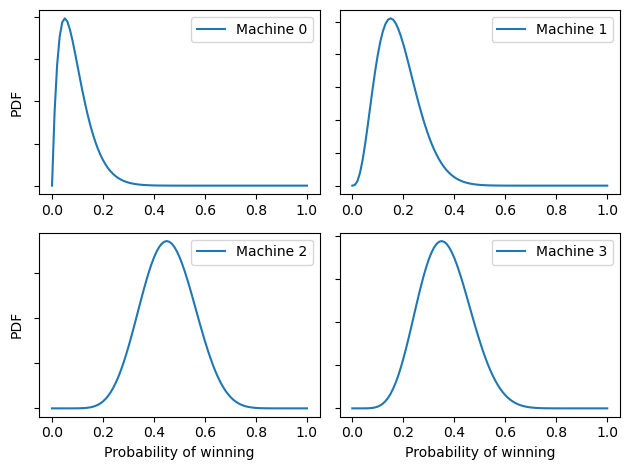

In [12]:
plot(beliefs)

In [13]:
import pandas as pd

def summarize_beliefs(beliefs):
    """Compute means and credible intervals.
    
    beliefs: sequence of Pmf
    
    returns: DataFrame
    """
    columns = ['Actual P(win)', 
               'Posterior mean', 
               'Credible interval']
    
    df = pd.DataFrame(columns=columns)
    for i, b in enumerate(beliefs):
        mean = np.round(b.mean(), 3)
        ci = b.credible_interval(0.9)
        ci = np.round(ci, 3)
        df.loc[i] = actual_probs[i], mean, ci
    return df

In [14]:
summarize_beliefs(beliefs)

,Actual P(win),Posterior mean,Credible interval
0,0.1,0.091,"[0.02, 0.21]"
1,0.2,0.182,"[0.07, 0.33]"
2,0.3,0.455,"[0.29, 0.63]"
3,0.4,0.364,"[0.21, 0.54]"


In [15]:
beliefs[0].choice(10)

array([0.07, 0.12, 0.16, 0.06, 0.16, 0.09, 0.06, 0.05, 0.04, 0.08])

In [19]:
# thompson sampling


samples = np.array([
    b.choice(1000)
    for b in beliefs
])
indices = np.argmax(samples, axis=0)
indices.shape

(1000,)

In [20]:
# The Pmf of these indices is the fraction of times each machine yielded the highest values.
pmf = ed.Pmf.from_seq(indices)
pmf

,probs
1,0.008
2,0.740
3,0.252


In [22]:
def choose(beliefs):
    """Use Thompson sampling to choose a machine.
    
    Draws a single sample from each distribution.
    
    returns: index of the machine that yielded the highest value
    """
    ps = [b.choice() for b in beliefs]
    return np.argmax(ps)

In [23]:
choose(beliefs)

2

In [24]:
def choose_play_update(beliefs):
    """Choose a machine, play it, and update beliefs."""
    
    # choose a machine
    machine = choose(beliefs)
    
    # play it
    outcome = play(machine)
    
    # update beliefs
    update(beliefs[machine], outcome)

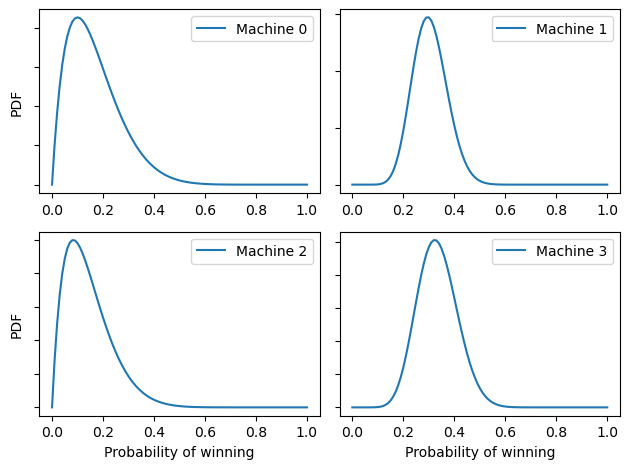

In [25]:
beliefs = [prior.copy() for i in range(4)]
counter = Counter()

num_plays = 100

for i in range(num_plays):
    choose_play_update(beliefs)
    
plot(beliefs)

In [26]:
summarize_beliefs(beliefs)

,Actual P(win),Posterior mean,Credible interval
0,0.1,0.167,"[0.03, 0.36]"
1,0.2,0.304,"[0.2, 0.42]"
2,0.3,0.143,"[0.03, 0.32]"
3,0.4,0.333,"[0.21, 0.47]"


In [27]:
def summarize_counter(counter):
    """Report the number of times each machine was played.
    
    counter: Collections.Counter
    
    returns: DataFrame
    """
    index = range(4)
    columns = ['Actual P(win)', 'Times played']
    df = pd.DataFrame(index=index, columns=columns)
    for i, count in counter.items():
        df.loc[i] = actual_probs[i], count
    return df

In [28]:
summarize_counter(counter)

,Actual P(win),Times played
0,0.1,10
1,0.2,44
2,0.3,12
3,0.4,34
